<font size="10">Tanner Sundwall - CS472 KNN Lab</font>

In [1]:
#from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import time

In [5]:
def calculate_distance(x1,x2,handle_nans=False): #input: 2 observations (np vectors)

    if not handle_nans:
        return np.linalg.norm(x1-x2)
    else:
        dist=0
        for pair in range(len(x1)):
            if np.isnan(x1[pair]) & np.isnan(x2[pair]):
                pass
            elif int(np.isnan(x1[pair])) + int(np.isnan(x2[pair])) == 1:

                dist+=((np.nanmax(x1)+np.nanmax(x2))/2)**2
            else:
                dist+=(x1[pair]-x2[pair])**2
        return dist


def pick_n_neighbors(new_x,X_hat,y_hat,n,handle_nans=False):

    distances = []
    distances_neighbors = []
    X_neighbors = []
    y_neighbors = []

    for obs in range(len(X_hat)): #create vector of distances
        curr_x = X_hat[obs,:]
        distances.append(calculate_distance(new_x,curr_x,handle_nans))

    for nth_neighbor in range(n):

        nth_neighbor_index = distances.index(np.min(distances))

        distances_neighbors.append(distances[nth_neighbor_index])
        X_neighbors.append(X_hat[nth_neighbor_index,:])

        if type(y_hat) == pd.core.series.Series: #IF ONLY 1 OUTPUT

            y_neighbors.append(y_hat[nth_neighbor_index])

        else:

            y_neighbors.append(y_hat[nth_neighbor_index,])

        del distances[nth_neighbor_index]

    return np.array(X_neighbors), np.array(y_neighbors), np.array(distances_neighbors)

def get_inverse_distance_weights(distances):

    return 1/((distances)**2)

def solve_obj_func(X_neighbors, y_neighbors, distances, out_type="classification", weighted=False):

    if out_type == "classification":

        if not weighted: #argmax is simply majority class
            outputs, counts = np.unique(y_neighbors, return_counts=True)
            return outputs[counts.argmax()]

        else:
            distance_terms = get_inverse_distance_weights(distances)

            arg_max = None
            max_value = 0

            for output_class in set(y_neighbors):

                unweighted_vector = kroenecker_delta(y_neighbors, output_class)
                obj_value = np.sum(np.multiply(distance_terms,unweighted_vector))

                if obj_value > max_value:
                    max_value = obj_value
                    arg_max = output_class

            return arg_max

    elif out_type == "Regression":

        if not weighted:

            return(np.mean(y_neighbors))

        else:

            distance_terms = get_inverse_distance_weights(distances)

            return np.dot(distance_terms,y_neighbors) / np.sum(distance_terms)


def partition_df(df, numOutputs):

    X = df.iloc[:,:len(df.columns)-numOutputs]
    y = df.iloc[:,-numOutputs]

    return X,y

def kroenecker_delta(output_vector, curr_class):
    return (output_vector == curr_class)*1

def evaluate_test_set(X_train, y_train, X_test, out_type="classification",weighted=False, k = 3, printStatus=False, handle_nans=False):

    preds = []
    count = 0

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()

    for obs in range(len(X_test)):

        count += 1
        if printStatus:
            if count % 500 == 0:
                print(f'Test observation: {count}')

        new_x = X_test[obs,:]
        X_neighbors, y_neighbors, distances = pick_n_neighbors(new_x,X_train,y_train,k,handle_nans=handle_nans)

        y_pred = solve_obj_func(X_neighbors, y_neighbors, distances, weighted=weighted, out_type=out_type)
        preds.append(y_pred)

    return preds

def score(y_preds,y_test):
    results = []
    if type(y_preds[0])!=np.float64:

        for result_index in range(len(y_preds)):
            results.append(y_preds[result_index]==y_test.iloc[result_index]*1)

        return np.mean(results)

    else:

        assert(len(y_preds)==len(y_test))
        diffs = y_preds-y_test
        return np.linalg.norm(diffs) / len(y_preds)


def normalize_X(X):
    for feature_index in range(len(X.columns)):
        feature = X.iloc[:,feature_index]
        maxVal = np.max(feature)
        minVal = np.min(feature)
        X.iloc[:,feature_index] = (X.iloc[:,feature_index] - minVal)/(maxVal-minVal)

def split_df(df, numOutputs, pctTraining, shuffle=True):

    if shuffle:
        df = df.sample(frac=1)
        df = df.reset_index(drop=True)

    nFeatures = len(df.columns) - numOutputs

    X = df.iloc[:, :nFeatures]
    y = df.iloc[:,nFeatures:]

    n = len(X)
    nSplit = int(n * pctTraining)
    XTraining = X[:nSplit]
    yTraining = y[:nSplit]
    XTest = X[nSplit:]
    yTest = y[nSplit:]

    return [XTraining, yTraining], [XTest, yTest]

def hot_encode(col,name):

    y = pd.Series(col)
    y = pd.get_dummies(y, columns = set(col),prefix = name)

    return y

Load in Data

In [3]:
data = arff.loadarff("glass_train.arff")
df_train = pd.DataFrame(data[0])
data = arff.loadarff("glass_test.arff")
df_test = pd.DataFrame(data[0])

X_train_gl,y_train_gl = partition_df(df_train,1)
X_test_gl,y_test_gl = partition_df(df_test,1)

data = arff.loadarff("diabetes_train.arff")
df_train = pd.DataFrame(data[0])
data = arff.loadarff("diabetes_test.arff")
df_test = pd.DataFrame(data[0])

X_train_dia,y_train_dia = partition_df(df_train,1)
X_test_dia,y_test_dia = partition_df(df_test,1)

data = arff.loadarff("magic_telescope_train.arff")
df_train = pd.DataFrame(data[0])
data = arff.loadarff("magic_telescope_test.arff")
df_test = pd.DataFrame(data[0])

X_train_mag,y_train_mag = partition_df(df_train,1)
X_test_mag,y_test_mag = partition_df(df_test,1)

data = arff.loadarff("housing_train.arff")
df_train = pd.DataFrame(data[0])
data = arff.loadarff("housing_test.arff")
df_test = pd.DataFrame(data[0])

for i in range(len(df_train)):
    df_train['CHAS'][i] = int.from_bytes(df_train['CHAS'][i],"little")-48

for i in range(len(df_test)):
    df_test['CHAS'][i] = int.from_bytes(df_test['CHAS'][i],"little")-48

X_train_hous,y_train_hous = partition_df(df_train,1)
X_test_hous,y_test_hous = partition_df(df_test,1)

data = arff.loadarff("credit_approval.arff")
df = pd.DataFrame(data[0])
X_cred,y_cred = partition_df(df,1)

C:\Users\Tanner\AppData\Local\Temp\ipykernel_18976\350249155.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['CHAS'][i] = int.from_bytes(df_train['CHAS'][i],"little")-48
C:\Users\Tanner\AppData\Local\Temp\ipykernel_18976\350249155.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CHAS'][i] = int.from_bytes(df_test['CHAS'][i],"little")-48


<font size="5">1.1.1- Debug</font>

In [6]:
y_preds = evaluate_test_set(X_train_gl, y_train_gl, X_test_gl)
print(f'Unweighted Test Accuracy: {score(y_preds,y_test_gl)}')
y_preds = evaluate_test_set(X_train_gl, y_train_gl, X_test_gl, weighted=True)
print(f'Weighted Test Accuracy: {score(y_preds,y_test_gl)}')


Unweighted Test Accuracy: 0.6463414634146342
Weighted Test Accuracy: 0.7682926829268293


<font size="5">1.1.2- Evaluate</font>


In [7]:
y_preds = evaluate_test_set(X_train_dia, y_train_dia, X_test_dia)
print(f'Unweighted Test Accuracy: {score(y_preds,y_test_dia)}')
y_preds = evaluate_test_set(X_train_dia, y_train_dia, X_test_dia, weighted=True)
print(f'Weighted Test Accuracy: {score(y_preds,y_test_dia)}')


Unweighted Test Accuracy: 0.7760416666666666
Weighted Test Accuracy: 0.8515625


<font size="5">2.1- Magic Dataset Evaluation</font>

In [8]:
y_preds = evaluate_test_set(X_train_mag, y_train_mag, X_test_mag)
print(f'Unweighted Test Accuracy: {score(y_preds,y_test_mag)}')

Unweighted Test Accuracy: 0.7568256825682568


<font size="5">2.2- Magic Dataset Evaluation (Normalized)</font>

In [11]:
normalize_X(X_train_mag)
normalize_X(X_test_mag)

y_preds = evaluate_test_set(X_train_mag, y_train_mag, X_test_mag)
print(f'Unweighted Test Accuracy (Normalized): {score(y_preds,y_test_mag)}')

Unweighted Test Accuracy (Normalized): 0.7481248124812481


Accuracy didn't appear to change much with normalized data. Normalization is typically effective when mean values of different features differ drastically in scale, as to "weigh" each feature equally. In the case of the magic telescope data, scales don't appear to be drastically different; which is likely why normalizing the data didn't improve test accuracy

<font size="5">2.3- Experimenting with k values</font>

In [ ]:
test_accuracies = []
k = []

for iter in range(1,17,2):
    print(f"Starting k = {iter}")
    now = time.time()
    y_preds = evaluate_test_set(X_train_mag, y_train_mag, X_test_mag, k=iter)#,printStatus=True
    test_accuracies.append(score(y_preds,y_test_mag))
    print(f"seconds elapsed: {int(time.time()-now)}")
    k.append(iter)

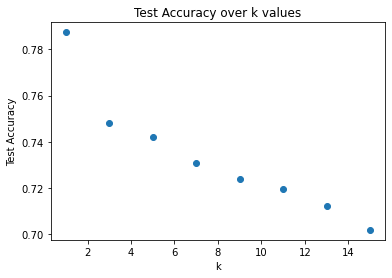

In [389]:
plt.scatter(k,test_accuracies)
plt.xlabel("k")
plt.ylabel("Test Accuracy")
foo = plt.title("Test Accuracy over k values")

<font size="5">3- Housing Dataset (KNN Regression)</font>

In [15]:
normalize_X(X_train_hous)
normalize_X(X_test_hous)

test_accuracies = []
k = []

for iter in range(1,17,2):
    y_preds = evaluate_test_set(X_train_hous, y_train_hous, X_test_hous, out_type="Regression", k = iter, printStatus=True)
    test_accuracies.append(score(y_preds,y_test_hous))
    k.append(iter)

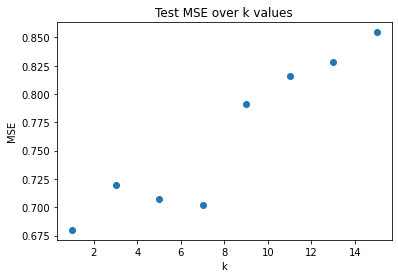

In [16]:
plt.scatter(k,test_accuracies)
plt.xlabel("k")
plt.ylabel("MSE")
foo = plt.title("Test MSE over k values")


It's worth noting that the behavior over k seen here reflects that of the magic dataset experiments; in this case, a positive slope denotes worsening models, since MSE indicates model inaccuracy. For the magic dataset, a negative slope denoted worsening models since the metric was accuracy.

<font size="5">4.1- Magic Dataset (Weighted)</font>

In [51]:
test_accuracies_magic_weighted = []
k = []

for iter in range(1,17,2):
    print(f"Starting k = {iter}")
    now = time.time()
    y_preds = evaluate_test_set(X_train_mag, y_train_mag, X_test_mag, k=iter, weighted=True)#,printStatus=True
    test_accuracies_magic_weighted.append(score(y_preds,y_test_mag))
    print(f"seconds elapsed: {int(time.time()-now)}")
    k.append(iter)

Starting k = 1


C:\Users\Tanner\AppData\Local\Temp\ipykernel_18976\989270201.py:66: RuntimeWarning: divide by zero encountered in true_divide
  return 1/((distances)**2)


seconds elapsed: 533
Starting k = 3


C:\Users\Tanner\AppData\Local\Temp\ipykernel_18976\989270201.py:86: RuntimeWarning: invalid value encountered in multiply
  obj_value = np.sum(np.multiply(distance_terms,unweighted_vector))


seconds elapsed: 506
Starting k = 5
seconds elapsed: 510
Starting k = 7
seconds elapsed: 487
Starting k = 9
seconds elapsed: 508
Starting k = 11
seconds elapsed: 510
Starting k = 13
seconds elapsed: 511
Starting k = 15
seconds elapsed: 537


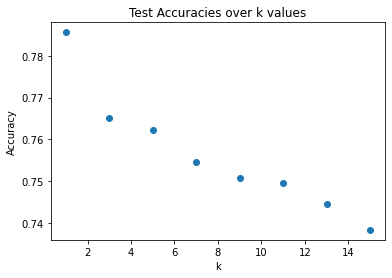

In [62]:
plt.scatter(k,test_accuracies_magic_weighted)
plt.xlabel("k")
plt.ylabel("Accuracy")
foo = plt.title("Test Accuracies over k values")

<font size="5">4.2- Housing Dataset (Weighted)</font>

In [48]:
test_accuracies_hous_weighted = []
k = []

for iter in range(1,17,2):
    y_preds = evaluate_test_set(X_train_hous, y_train_hous, X_test_hous, out_type="Regression", k = iter, weighted=True)
    test_accuracies_hous_weighted.append(score(y_preds,y_test_hous))
    k.append(iter)

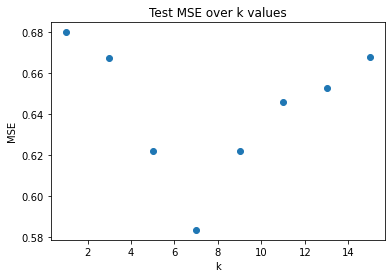

In [18]:
plt.scatter(k,test_accuracies_hous_weighted)
plt.xlabel("k")
plt.ylabel("MSE")
foo = plt.title("Test MSE over k values")


<font size="5">4.3-Discuss</font>

For the magic dataset MSEs were slightly lower across the board; k=1 had the best accuracy (0.79). Other than k=1 for the unweighted instances, the differences were large; k>1 accuracies for weighted were between 0.74 and 0.76, while unweighted were between 0.7 and 0.74. The shape of the graph remains the same; as k increases, voting becomes diluted.

For the housing dataset, MSE is lower across all k values. As seen above, the highest MSE is 0.68, which is higher than the lowest MSE for the unweighted analysis done previously. Especially within the scope of regression, where the output is any real value, weighting the distances makes a lot of sense; the output of the new datapoint is essentially a convex combination of all k neighbors.

The behavior across k is slightly different in the weighted case, however; a clear minima exists (k=7). In the unweighted case, it seemed reasonable to just take a very low k value. But here, very low k values have some sort of information loss.

Overall, the housing dataset MSE (0.58 at the lowest) improved accuracy drastically.

The clear difference is that the magic dataset (maybe due to its nominal output) was far less affected by weighting, and the behavior across different k values was as well.

<font size="5">5-Credit Approval Dataset</font>

In [59]:
for column in X_cred.columns:
    if X_cred[column].dtypes == object:
        hot_cols = hot_encode(X_cred[column],column)
        del X_cred[column]
        X_cred = pd.concat([X_cred,hot_cols],axis=1)

normalize_X(X_cred)

train,test = split_df(pd.concat([X_cred,y_cred],axis=1),1,.7)
y_preds = evaluate_test_set(train[0], train[1].squeeze(), test[0], weighted=True, k=7, handle_nans=True)

print(f'Weighted Test Accuracy (k=7): {score(y_preds,test[1])}')

Weighted Test Accuracy (k=7): 0.8269230769230769


I used k=7 as a hyperparameter, as it performed well in the MSE analyses above. Test accuracy was quite good; typically in the low 80%s. Here was my methodology in dealing with nominal/missing data:

* All nominal features were one-hot encoded, with each value getting its own column. This greatly expanded the feature space visually, as 51 feature columns existed after this transformation. Note that any nominal features with missing values received an extra column for this "value".
* Data was normalized such that each column ranged between 0 and 1. This plays an important role in the distance metric used. NaNs in continuous fields did not change
* When evaluating distance, nominal data were treated just like continuous data. Although it is discrete, the scales were the same, due to normalization; therefore, if values didn't match, the distance would be 1 (just as if a value of 0 and the max value in the column were evaluated for some normalized continuous data). This means that for nominal missing values, distance was maximized when they didn't match, and distance was zero when *features where both were unknown*
* For the continuous data, if a NaN appeared, it was evaluated against the other observation. If both had NaNs for the same feature, distance was 0, and a distance of 1 otherwise

Overall, the missing values were treated like any other attribute for nominal data (we assume missing values have intrinsic meaning), and treated as discrete 0 or 1 outputs of the Kroenecker function for continuous data

<font size="5">6-sklearn</font>

In [46]:

encode = preprocessing.LabelEncoder()
y_train_mag_enc = pd.DataFrame(y_train_mag).apply(encode.fit_transform)
y_test_mag_enc = pd.DataFrame(y_test_mag).apply(encode.fit_transform)

knn = KNeighborsClassifier(n_neighbors=10,weights='distance')
knn.fit(X_train_mag,y_train_mag_enc)

acc_mag = knn.score(X_test_mag,y_test_mag_enc)
print(f"Magic Dataset Accuracy (Weighted, k=10): {acc_mag}")

C:\Users\Tanner\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Magic Dataset Accuracy (Weighted, k=10): 0.8222322232223223


In [47]:
knn = KNeighborsRegressor(n_neighbors=2,weights='distance')
knn.fit(X_train_hous,y_train_hous)
y_pred = knn.predict(X_test_hous)
mse_hous = score(y_pred,y_test_hous)
print(f"Housing Test MSE (Weighted, k=2): {mse_hous}")

Housing Test MSE (Weighted, k=2): 0.47967874180434605


Across hyperparameters, the sklearn implementation performed significantly better on the housing dataset; MSEs in my algorithm didn't get any lower than 0.65, while the sklearn implementation returned 0.53.

The magic dataset performed very similarly to my algorithm here. This could either be attributed to the dataset itself, or the KNN method used (classification instead of regression).

It's also worth noting that the sklearn algorithm is *significantly* faster. This is likely due to the 'ball tree' implementation used in sklearn; which induces a tree that relates nearby datapoints before the algorithm begins. This eliminates a vast amount of re-computation of distances; a new datapoint is just checked against the tree.

When experimenting with parameters, I found that the distance metric seemed inconclusive; the l1 and l2 norms, along with Minkowski distance, performed differently on either dataset. Because of this, i kept p=2 for interpretability.

I also played around with the leaf_size argument. This didn't affect accuracy, but it likely affects performance (choosing the most efficient tree structure). Any performance changes were negligible at this small problem size.

Using weighted distance improved results, but only slightly (as opposed to my model, which performed significantly better with weighted distance).

For the housing dataset, k=2 was the optimal neighbor size. MSE starts to increase rapidly as k increase past 5. This has a similar shape to the graph of the weighted distances KNN iterations from earlier.

The magic dataset is a bit more unclear as far as the best k value goes. As k gets large, accuracy doesn't decrease; but theoretically, the computation time does. I settled with k=10.


